## XGBoost
This notebook is created to experiment with the machine learning algorithm XGboost: 
1. Classifier
2. Regressor
3. hyperparamter Tuning
4. XGboost in pipelines

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [ ]:
df = pd.read_csv("Utility_files/datasets_course1_DC/telecom_churn_clean.csv")

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
X = df.drop(['churn'], axis=1).values
y = df['churn'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [ ]:
churn_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="error", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the accuracy
print(((1-cv_results["test-error-mean"]).iloc[-1]))

In [ ]:
# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])

### Loss functions
In XGBoost model, there are a number of possible loss functions: 
* reg:linear: for regression problem
* reg: logistic: for classification problems, where the probability of a prediction is not considered
* binary: logistic: for classificaiton problems where the probability of a prediciton is still valuable.

The individual weak learners also referred to as base learners. Base learners trained on a subset of the data, as well as subset of features so that each learner becomes better at predicting a part of the data while being weak on other parts. Combined, these bad predictions cancel out and the final prediction is non-linear.

In [ ]:
## dataset for regression
df1 = pd.read_csv("Utility_files/datasets_course1_DC/advertising_and_sales_clean.csv")
# print(df1)
df1 = pd.get_dummies(df1)

X = df1.drop('sales', axis=1).values
y = df1["sales"].values

In [ ]:
from sklearn.metrics import mean_squared_error
## XGboost for regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=123)  # this is default XGboost model built upon decision tree learners

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

In [ ]:
## to apply XGboost with other learners such as Linear Regression using the XGBoost independent library is necessary

# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"} # using Linear Regression models

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

Using decision trees is significantly much more efficient.

In [22]:

# Create the DMatrix: dm
dm = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=dm, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2          rmse
0    1  36684.101652
1   10  38813.444005
2  100  49429.219949


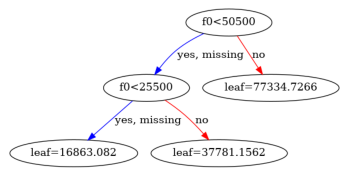

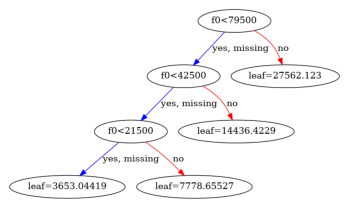

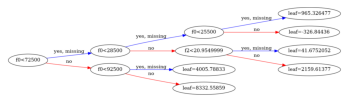

In [25]:
# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dm, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg,num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg,num_trees=9, rankdir='LR')
plt.show()

In [ ]:
cv_results = xgb.cv(dtrain=dm, params=params, nfold=3, 
metrics='rmse', num_boost_round=50, early_stopping_rounds=10, 
as_pandas=True, seed=123) 

In [26]:
## tuning with GridSearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3,0.7],
    'n_estimators': [50],
    'max_depth': [2, 5]
}



# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
grid_mse = GridSearchCV(gbm, param_grid=gbm_param_grid, scoring='neg_mean_squared_error', cv=4, verbose=1)


# Fit grid_mse to the data
grid_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters found:  {'colsample_bytree': 0.7, 'max_depth': 5, 'n_estimators': 50}
Lowest RMSE found:  5476.860146383742


consider all the hyperparamters of XGBoost [here](XGBoost_hyper_params.png)